* Python code replication of: " https://www.kaggle.com/janniskueck/pm1-notebook-inference "
* Created by: Anzony Quispe & Alexander Quispe

This notebook contains an example for teaching.

# An inferential problem: The Gender Wage Gap

In the previous lab, we already analyzed data from the March Supplement of the U.S. Current Population Survey (2015) and answered the question how to use job-relevant characteristics, such as education and experience, to best predict wages. Now, we focus on the following inference question:

What is the difference in predicted wages between men and women with the same job-relevant characteristics?

Thus, we analyze if there is a difference in the payment of men and women (*gender wage gap*). The gender wage gap may partly reflect *discrimination* against women in the labor market or may partly reflect a *selection effect*, namely that women are relatively more likely to take on occupations that pay somewhat less (for example, school teaching).

To investigate the gender wage gap, we consider the following log-linear regression model

\begin{align}
\log(Y) &= \beta'X + \epsilon\\
&= \beta_1 D  + \beta_2' W + \epsilon,
\end{align}

where $D$ is the indicator of being female ($1$ if female and $0$ otherwise) and the
$W$'s are controls explaining variation in wages. Considering transformed wages by the logarithm, we are analyzing the relative difference in the payment of men and women.

## Data analysis

We consider the same subsample of the U.S. Current Population Survey (2015) as in the previous lab. Let us load the data set.

In [1]:
import pandas as pd
import numpy as np
import pyreadr 
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rdata_read = pyreadr.read_r("../data/wage2015_subsample_inference.Rdata")

# Extracting the data frame from rdata_read
data = rdata_read[ 'data' ]

data.shape

(5150, 20)

In [3]:
data["anyclg"] = 0
data

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,...,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2,anyclg
rownames,,,,,,,,,,,,,,,,,,,,,
10,9.615385,2.263364,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,7.0,0.49,0.343,0.2401,3600,11,8370,18,0
12,48.076923,3.872802,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,31.0,9.61,29.791,92.3521,3050,10,5070,9,0
15,11.057692,2.403126,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,18.0,3.24,5.832,10.4976,6260,19,770,4,0
18,13.942308,2.634928,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,25.0,6.25,15.625,39.0625,420,1,6990,12,0
19,28.846154,3.361977,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,22.0,4.84,10.648,23.4256,2015,6,9470,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32620,14.769231,2.692546,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,9.0,0.81,0.729,0.6561,4700,16,4970,9,0
32624,23.076923,3.138833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,12.0,1.44,1.728,2.0736,4110,13,8680,20,0
32626,38.461538,3.649659,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,11.0,1.21,1.331,1.4641,1550,4,3680,6,0


In [4]:
data.loc[(data[ 'scl' ] == 1) |(data[ 'clg' ] == 1),'anyclg'] = 1
data

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,...,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2,anyclg
rownames,,,,,,,,,,,,,,,,,,,,,
10,9.615385,2.263364,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,7.0,0.49,0.343,0.2401,3600,11,8370,18,1
12,48.076923,3.872802,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,31.0,9.61,29.791,92.3521,3050,10,5070,9,1
15,11.057692,2.403126,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,18.0,3.24,5.832,10.4976,6260,19,770,4,0
18,13.942308,2.634928,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,25.0,6.25,15.625,39.0625,420,1,6990,12,0
19,28.846154,3.361977,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,22.0,4.84,10.648,23.4256,2015,6,9470,22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32620,14.769231,2.692546,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,9.0,0.81,0.729,0.6561,4700,16,4970,9,1
32624,23.076923,3.138833,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,12.0,1.44,1.728,2.0736,4110,13,8680,20,1
32626,38.461538,3.649659,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,11.0,1.21,1.331,1.4641,1550,4,3680,6,0


To start our (causal) analysis, we compare the sample means given gender:

In [7]:
data = data[data["anyclg"]==1]
data.shape

(3068, 21)

In [8]:
Z = data[ ["lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"] ]

data_female = data[data[ 'sex' ] == 1 ]
Z_female = data_female[ ["lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"] ]

data_male = data[ data[ 'sex' ] == 0 ]
Z_male = data_male[ [ "lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1" ] ]


table = np.zeros( (12, 3) )
table[:, 0] = Z.mean().values
table[:, 1] = Z_male.mean().values
table[:, 2] = Z_female.mean().values
table_pandas = pd.DataFrame( table, columns = [ 'All', 'Men', 'Women'])
table_pandas.index = ["Log Wage","Sex","Less then High School","High School Graduate","Some College","Gollage Graduate","Advanced Degree", "Northeast","Midwest","South","West","Experience"]
table_html = table_pandas.to_html()

table_pandas

,All,Men,Women
Log Wage,3.000022,3.038412,2.956904
Sex,0.470991,0.000000,1.000000
Less then High School,0.000000,0.000000,0.000000
High School Graduate,0.000000,0.000000,0.000000
Some College,0.466754,0.481824,0.449827
Gollage Graduate,0.533246,0.518176,0.550173
Advanced Degree,0.000000,0.000000,0.000000
Northeast,0.226532,0.219347,0.234602
Midwest,0.265971,0.261245,0.271280
South,0.285854,0.290819,0.280277


In [11]:
print( table_html )

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>All</th>
      <th>Men</th>
      <th>Women</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Log Wage</th>
      <td>3.000022</td>
      <td>3.038412</td>
      <td>2.956904</td>
    </tr>
    <tr>
      <th>Sex</th>
      <td>0.470991</td>
      <td>0.000000</td>
      <td>1.000000</td>
    </tr>
    <tr>
      <th>Less then High School</th>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>High School Graduate</th>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>Some College</th>
      <td>0.466754</td>
      <td>0.481824</td>
      <td>0.449827</td>
    </tr>
    <tr>
      <th>Gollage Graduate</th>
      <td>0.533246</td>
      <td>0.518176</td>
      <td>0.550173</td>
    </tr>
    <tr>
      <th>Advanced Degree</th>
      <td>0.000000</td>
      <td>0.000000</td>
 

In particular, the table above shows that the difference in average *logwage* between men and women is equal to $0,038$

In [12]:
data_female['lwage'].mean() - data_male['lwage'].mean()

-0.08150855508736621

Thus, the unconditional gender wage gap is about $-8,1$\%, we can see that there are more mens with unfinished college that complete college. On the other hand, there are more womans with unfinished college that womans with finished college.

This unconditional (predictive) effect of gender equals the coefficient $\beta$ in the univariate ols regression of $Y$ on $D$:

\begin{align}
\log(Y) &=\beta D + \epsilon.
\end{align}

We verify this by running an ols regression in R.

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [14]:
nocontrol_model = smf.ols( formula = 'lwage ~ sex', data = data )
nocontrol_est = nocontrol_model.fit().summary2().tables[1]['Coef.']['sex']
nocontrol_model.fit().cov_HC0

array([[ 0.00019006, -0.00019006],
       [-0.00019006,  0.00038336]])

In [15]:
nocontrol_model = smf.ols( formula = 'lwage ~ sex', data = data )
nocontrol_est = nocontrol_model.fit().summary2().tables[1]['Coef.']['sex']
HCV_coefs = nocontrol_model.fit().cov_HC0
nocontrol_se = np.power( HCV_coefs.diagonal() , 0.5)[1]

# print unconditional effect of gender and the corresponding standard error
print( f'The estimated gender coefficient is {nocontrol_est} and the corresponding robust standard error is {nocontrol_se}' )

The estimated gender coefficient is -0.08150855508736154 and the corresponding robust standard error is 0.019579647767772344


Note that the standard error is computed with the *R* package *sandwich* to be robust to heteroskedasticity. 


Next, we run an ols regression of $Y$ on $(D,W)$ to control for the effect of covariates summarized in $W$:

\begin{align}
\log(Y) &=\beta_1 D  + \beta_2' W + \epsilon.
\end{align}

Here, we are considering the flexible model from the previous lab. Hence, $W$ controls for experience, education, region, and occupation and industry indicators plus transformations and two-way interactions.

Let us run the ols regression with controls.

## Ols regression with controls

In [16]:
flex = 'lwage ~ sex + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)'

# The smf api replicates R script when it transform data
control_model = smf.ols( formula = flex, data = data )
control_est = control_model.fit().summary2().tables[1]['Coef.']['sex']

print(control_model.fit().summary2().tables[1])
print( f"Coefficient for OLS with controls {control_est}" )

HCV_coefs = control_model.fit().cov_HC0
control_se = np.power( HCV_coefs.diagonal() , 0.5)[1]

               Coef.  Std.Err.         t         P>|t|    [0.025    0.975]
Intercept   2.073357  0.214419  9.669647  8.761691e-22  1.652924  2.493790
occ2[T.10]  0.091982  0.243220  0.378184  7.053225e-01 -0.384925  0.568888
occ2[T.11] -0.499418  0.436858 -1.143202  2.530511e-01 -1.356010  0.357175
occ2[T.12]  0.190101  0.341142  0.557249  5.774012e-01 -0.478810  0.859012
occ2[T.13] -0.194529  0.271881 -0.715492  4.743637e-01 -0.727633  0.338575
...              ...       ...       ...           ...       ...       ...
exp4:scl    0.021375  0.022071  0.968465  3.328946e-01 -0.021902  0.064653
exp4:clg    0.007909  0.021929  0.360650  7.183881e-01 -0.035090  0.050908
exp4:mw     0.014287  0.025814  0.553477  5.799802e-01 -0.036328  0.064902
exp4:so    -0.003759  0.022547 -0.166725  8.675981e-01 -0.047968  0.040450
exp4:we     0.028286  0.023812  1.187890  2.349761e-01 -0.018405  0.074978

[246 rows x 6 columns]
Coefficient for OLS with controls -0.053062340357748546


The estimated regression coefficient $\beta_1\approx-0.05$ measures how our linear prediction of wage changes if we set the gender variable $D$ from 0 to 1, holding the controls $W$ fixed.
We can call this the *predictive effect* (PE), as it measures the impact of a variable on the prediction we make. Overall, we see that the unconditional wage gap of size $8.1$\% for women increases to about $5.3$\% after controlling for worker characteristics.  


Next, we are using the Frisch-Waugh-Lovell theorem from the lecture partialling-out the linear effect of the controls via ols.

## Partialling-Out using ols

In [17]:
# models
# model for Y
flex_y = 'lwage ~  (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)'
# model for D
flex_d = 'sex ~ (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)' 

# partialling-out the linear effect of W from Y
t_Y = smf.ols( formula = flex_y , data = data ).fit().resid

# partialling-out the linear effect of W from D
t_D = smf.ols( formula = flex_d , data = data ).fit().resid

data_res = pd.DataFrame( np.vstack(( t_Y.values , t_D.values )).T , columns = [ 't_Y', 't_D' ] )
# regression of Y on D after partialling-out the effect of W
partial_fit =  smf.ols( formula = 't_Y ~ t_D' , data = data_res ).fit()
partial_est = partial_fit.summary2().tables[1]['Coef.']['t_D']

print("Coefficient for D via partialling-out", partial_est)

# standard error
HCV_coefs = partial_fit.cov_HC0
partial_se = np.power( HCV_coefs.diagonal() , 0.5)[1]

# confidence interval
partial_fit.conf_int( alpha=0.05 ).iloc[1, :]

Coefficient for D via partialling-out -0.05306234035775369


0   -0.089571
1   -0.016554
Name: t_D, dtype: float64

Again, the estimated coefficient measures the linear predictive effect (PE) of $D$ on $Y$ after taking out the linear effect of $W$ on both of these variables. This coefficient equals the estimated coefficient from the ols regression with controls.

We know that the partialling-out approach works well when the dimension of $W$ is low
in relation to the sample size $n$. When the dimension of $W$ is relatively high, we need to use variable selection
or penalization for regularization purposes. 

## Graphic

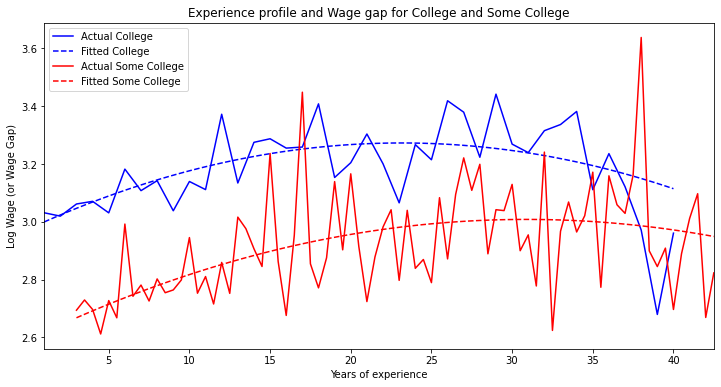

In [22]:
plt.figure(figsize=(12,6))

ax=sns.lineplot(x=data[data['clg']==1].exp1,y=data[data['clg']==1].lwage,estimator=np.mean,color='b',ci=None)
sns.regplot(x=data[data['clg']==1].exp1,y=data[data['clg']==1].lwage,color='blue',scatter=False,order=2,x_jitter=.001,x_estimator=np.mean,fit_reg=True,ci=None,line_kws={'lw':1.5})
sns.lineplot(x=data[data['scl']==1].exp1,y=data[data['scl']==1].lwage,estimator=np.mean,color='r',ci=None)
sns.regplot(x=data[data['scl']==1].exp1,y=data[data['scl']==1].lwage,color='red',scatter=False,order=2,x_jitter=.001,x_estimator=np.mean,fit_reg=True,ci=None,line_kws={'lw':1.5})
ax.lines[1].set_linestyle("--")
ax.lines[3].set_linestyle("--")
plt.xlabel('Years of experience')
plt.ylabel('Log Wage (or Wage Gap)')
plt.title('Experience profile and Wage gap for College and Some College')
plt.legend(['Actual College','Fitted College','Actual Some College','Fitted Some College'])

# The proof of the Frisch-Waugh-Lovell Theorem

We can start defining the main equation as:

\begin{align} 
Y= D \beta_1 + W \beta_2 + e
\end{align}

Since we want to find $\beta_1$, we can use the **F-W-L Theorem** to proof that we can find it by partialling-out. For that, first, we need to start by regressing $Y$ with $W$ and $D$ with $W$:

 \begin{align} 
Y=\alpha_{YW} W+ e_1 \\
D=\alpha_{DW} W+ e_2 \\
\end{align}

With this, we can estimate the residual errors $\hat{e_1}$ and $\hat{e_2}$ after estimating the coefficients $\hat{\alpha_{YW}}$  and $\hat{\alpha_{DW}}$ using OLS. We can present them using the *waste generation matrix*:

\begin{align} 
\hat{e_1}&= Y- W \hat{\alpha_{YW}} \\
&= Y- W (W'W)^{-1} W' Y\\
&= (I-W (W'W)^{-1} W')Y\\
&=MY
\end{align}

\begin{align} 
\hat{e_2}&= D- W \hat{\alpha_{DW}} \\
&= D- W (W'W)^{-1} W' D\\
&= (I-W (W'W)^{-1} W')D\\
&=MD
\end{align}

An interesting property of this waste generation matrix is that is *idempotent* meaning it follows:

\begin{align} 
M M &=  (I-W (W'W)^{-1} W')  (I-W (W'W)^{-1} W') \\
&= I - W (W'W)^{-1} W' - W (W'W)^{-1} W' +  W (W'W)^{-1} W' W (W'W)^{-1} W'\\
&= I - 2 W (W'W)^{-1} W' +  W (W'W)^{-1} W' \\
&= I - W (W'W)^{-1} W' \\
&= M
\end{align}

With this in mind, we can regress $\hat{e_1}$ and $\hat{e_2}$ using OLS:

\begin{align} 
\hat{e_1}=\hat{e_2}+\alpha_{e_1 e_2} + e_3
\end{align}

And find that $\hat{\alpha_{e_1 e_2}}$= $\beta_1$, proving the **F-W-L Theorem**:

\begin{align} 
\hat{\alpha_{e_1 e_2}}&=(\hat{e_2}' \hat{e_2}) ^{-1} (\hat{e_2}'\hat{e_1}) \\
&= ( ( MD)' MD )^{-1} ( (MD)' MY) \\
&= (D'M'M D ) ^{-1} (D'M'M Y) \\
&= (D'D)^{-1} (D'Y) \\
&= \beta_1
\end{align}